# Example fitting notebook

This notebook shows an example of fitting a dataset using `metaldisc`. It is identical to the `fit_from_sfrmap.py` routine but is more adapted for learning and exploring. It runs a very simple fit.

In [1]:
from __future__ import absolute_import
import numpy as np

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM

from metaldisc.fluxgrid import FluxGrid
from metaldisc.galaxy import GalaxyMap
from metaldisc.seeing import MoffatPSF
from metaldisc.obssim import BinmapObsSim, ImageObsSim
from metaldisc.fitting import MultinestFitting
import os

The following packages are not part of standard `metaldisc` but they are useful for parsing results

In [13]:
import pymultinest
from getdist import plots, MCSamples, chains, loadMCSamples
import json

## Setup routines

These are the same routines as in the model exploration routine. Again they are a bit hard-coded for this particular galaxy. We set up the flux grid, the seeing model, the galaxy model, the observation model and the fitting model.

In [3]:
def init_fluxgrid():
    """Initialize emission-line model instance"""
    #select model grid to use
    grid = '../grids/grid_Dopita13_kappa=inf.h5'

    #list of line names that we will be using
    lines = ['O2-3727', 'O2-3729', 'Hg', 'Hb', 'O3-5007']
    #these names must match those defined in the model grid file
    
    #preload model flux grid
    fluxgrid = FluxGrid(grid, lines)

    return fluxgrid


def init_seeing(file_):
    """Initialize PSF model instance"""

    with fits.open(file_, mode='readonly') as fh:
        #get psf info
        psf_data = np.array(fh['psf'].data)

    seeing = MoffatPSF(psf_data['wave'], psf_data['fwhm'], psf_data['beta'])

    return seeing


def init_galaxy(file_, fluxgrid):
    """Initialize galaxy model instance"""

    with fits.open(file_, mode='readonly') as fh:
        #get basic info from primary header
        ra = fh[0].header['RA'] #ra of galaxy centre
        dec = fh[0].header['Dec'] #dec of galaxy centre
        z = fh[0].header['z'] #redshift

        inc = fh[0].header['inc'] #disc inclination
        pa = fh[0].header['pa'] #position angle (North=0, East=90)

        #get approximate SFR map to be used as a fixed model input
        sfrmap = fh['sfrmap'].copy()
        #sfrmap must be a fits ImageHDU with the correct WCS information

    #choose a cosmology used to calcuate luminosity distance
    cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

    galaxy = GalaxyMap(sfrmap, ra, dec, z, pa, inc, cosmo, fluxgrid)

    return galaxy


def init_obssim(file_, galaxy, seeing):
    """Initialize observation model instance"""

    with fits.open(file_, mode='readonly') as fh:
        #get segmentation map indicating spatial positions of the above emission
        #line fluxes 

        binmap = fh['binmap'].copy()
        #binmap must be a fits ImageHDU with the correct WCS information

    obssim = BinmapObsSim(binmap, galaxy, seeing)

    return obssim


def init_fitter(file_, obssim):


    with fits.open(file_, mode='readonly') as fh:
        #get observed fluxes and associated errors 
        flux = np.array(fh['flux'].data)
        flux_err = np.array(fh['flux_err'].data)

        #flux and flux_err are structured arrays
        #use magic to convert them to regular arrays
        flux = flux.view((flux.dtype[0], len(flux.dtype.names)))
        flux_err = flux_err.view((flux_err.dtype[0], len(flux_err.dtype.names)))


    #convert flux errors to variances
    flux_var = flux_err ** 2.

    #list of line names that we will be using
    lines = [['O2-3727', 'O2-3729'], ['Hg'], ['Hb'], ['O3-5007']]
    #len(lines) must equal the number of columns in the observed flux array

    #note here the nested list ['O2-3727', 'O2-3729'] indicates that these lines
    #are to be coadded (because this is how the observed fluxes are provided)
    
    #additional 4% error to add to model line fluxes
    model_err = np.array([0.04, 0.04, 0.04, 0.04, 0.04])


    #initialize fitter with default priors
    fitter = MultinestFitting(lines, flux, flux_var, obssim, model_err)

    return fitter


# Running the fit

To run the fit, we first need to load in the galaxy data and set things up and then set the number of live points and sampling efficiency of the fit and then run multinest. 

In [4]:
#data file
file_ = 'example_HDFS_0003.fit'

#build up model from components
fluxgrid = init_fluxgrid()
seeing = init_seeing(file_)
galaxy = init_galaxy(file_, fluxgrid)
obssim = init_obssim(file_, galaxy, seeing)
fitter = init_fitter(file_, obssim)

In [5]:
#now run the fitter and store the results in the "out" directory

#set multinest parameters
#N.B. These are definitely NOT sensible defaults! (they are simply choosen
#to make this example run faster)
sampling_efficiency = 1.0 #0.3 -- 0.8 would be more sensible choices
n_live_points = 100       #>500 would be more a sensible choice

#create output directory if needed
try:
    os.mkdir('out')
except OSError:
    pass


And finally, we run the actual multinest setup. This takes a while!

In [6]:
# This is commented out so that an automatic run of the notebook does not run this.
#fitter.multinest_run('out/0-', sampling_efficiency=sampling_efficiency,
#                     n_live_points=n_live_points)


## Reading the fit results

This goes beyond the example code. Here we use `getdist` to read in the chains and do statistics. For this to work, it is necessary to write a file called e.g. `out/1-.paramnames` which contains the parameter names. 

In [7]:
parameters = json.load(open("out/1-params.json"))

In [18]:
a = pymultinest.Analyzer(n_params=len(parameters), outputfiles_basename="out/1-")

  analysing data from out/1-.txt


In [19]:
samples = loadMCSamples(a.outputfiles_basename, no_cache=True, settings={'ignore_rows': 0.1})

out/1-.txt
Removed 0.1 as burn in


In [20]:
nm = samples.getParamNames()

In [22]:
nm.setLabels(parameters)

In [23]:
nm.setWithNames(parameters)

In [24]:
samples.setParamNames(nm)

In [25]:
samples.updateBaseStatistics()

In [26]:
g = plots.getSubplotPlotter()        

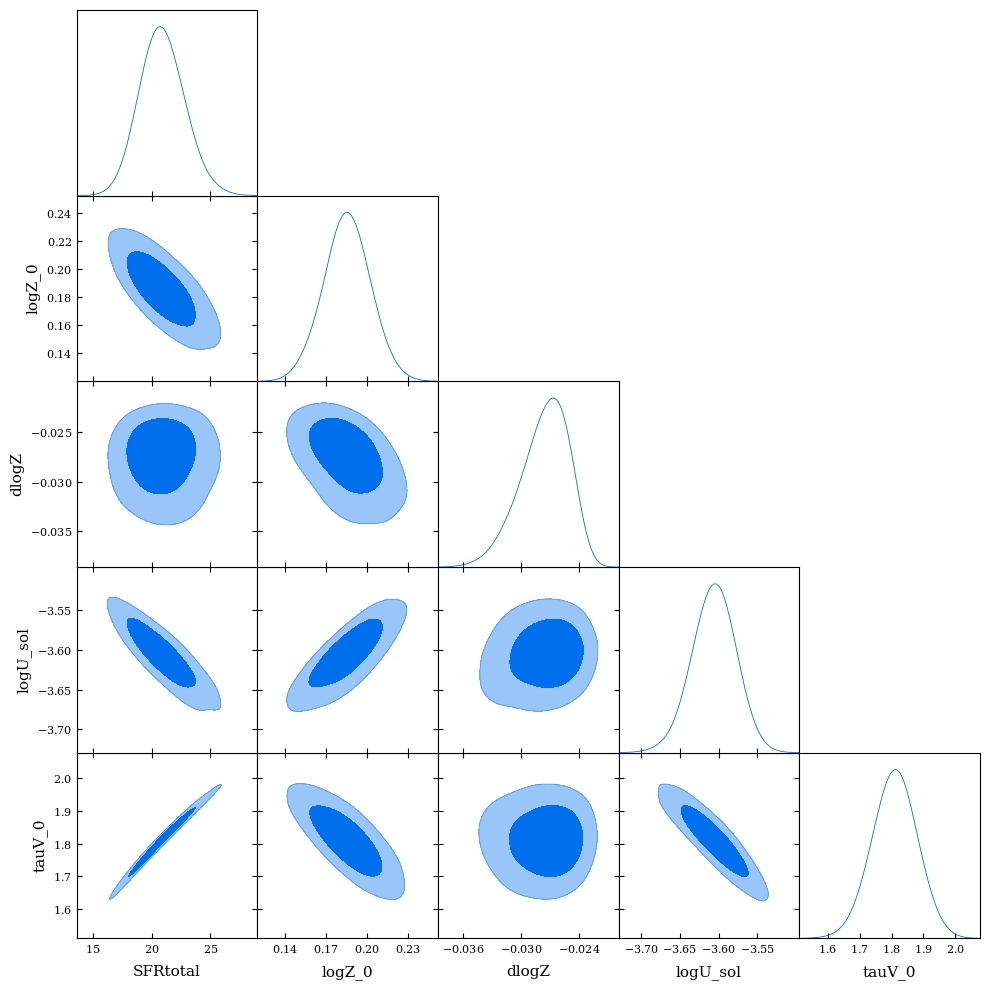

In [27]:
g.triangle_plot(samples, filled=True, params=parameters)